# March Machine Learning Mania 2017

In this Kaggle contest, one is required to predict the outcome of NCAA Men's division I's outcome, or alternatively, the result of march mania basketball game. Given several sheets of historical basketball playing record, this year's match result is to be predicted on every possible pair among the 68 selected teams. There's no restriction on the data source, however, this solution only restricts on the dataset given by Kaggle.

The idea of my solution is quite straightforward and simple. A previous trial on prediction using seed difference only already gives good results. My solution is just improvement on this starting point.

## 1. Statistical feature generation

Following the idea that this year's tournament result be predicted on identical season's regular season performance, each team will be generated with different features in different years.

I in this solution generated 25 statistical features besides seed difference: 

1. Num of wins in regular season
2. Num of significant wins in regular season
3. Num of significant loses in regular season
4. Seed in tournament
5. Score average
6. TO average
7. AST average
8. OR average
9. DR average
10. STL average
10. BLK average
11. PF average
12. EfgO
13. EfgD
14. TopO
15. TopD
16. ORB
17. DRB
18. OFT
19. DFT
20. AstO
21. AstD
22. FGrate
23. FG3rate
24. FTrate
25. AstTo

In [334]:
import pandas as pd
import numpy as np


regular = pd.read_csv("./Data/RegularSeasonDetailedResults.csv")
regular_rev = regular.ix[:, [0,1,4,5,2,3,7,21,22,23,24,25,26,27,28,29,30,31,32,33,8,9,10,11,12,13,14,15,16,17,18,19,20]]
new_regular = pd.DataFrame(np.vstack([regular_rev.values, 
                                   regular.ix[:, [0,1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]].values], 
                                 ), columns = ["Season","Daynum","Player","PlayerScore","Opponent","OpponentScore","Numot","Wfgm","Wfga","Wfgm3","Wfga3","Wftm","Wfta","Wor","Wdr","Wast","Wto","Wstl","Wblk","Wpf","Lfgm","Lfga","Lfgm3","Lfga3","Lftm","Lfta","Lor","Ldr","Last","Lto","Lstl","Lblk","Lpf"])
loc = []
revloc = []
for itm in regular['Wloc'].values:
    if itm=='N':
        loc.append(0)
        revloc.append(0)
    elif itm=='H':
        loc.append(1)
        revloc.append(-1)
    else:
        loc.append(-1)
        revloc.append(1)
new_regular['PlayerLoc']=np.hstack([revloc, loc])
new_regular['PlayerResult']=np.hstack([-1*np.ones(regular.shape[0], dtype=np.int), np.ones(regular.shape[0], dtype=np.int)])

In [335]:
# generate significant wins, significant lose, and location weight
marginal_thres = 5
sigwin = ((new_regular.loc[:, 'PlayerScore']-new_regular.loc[:, 'OpponentScore'])>marginal_thres).astype(np.int)
siglose = ((new_regular.loc[:, 'PlayerScore']-new_regular.loc[:, 'OpponentScore'])<-marginal_thres).astype(np.int)
locweight = (-new_regular.loc[:, 'PlayerLoc'])*0.5+1
new_regular['SigWin'] = sigwin
new_regular['SigLose'] = siglose
new_regular['LocWeight'] = locweight

In [336]:
# generate features 1,2,3
feature = new_regular.loc[:, ["Season", "Player", "PlayerResult", "SigWin", "SigLose"]].groupby(['Season', 'Player']).sum()
# generate features 5-12
feature = pd.merge(feature,
                   new_regular.loc[:, ["Season", "Player", "PlayerScore", "Wor","Wdr","Wast","Wto","Wstl","Wblk","Wpf"]].groupby(['Season', 'Player']).mean(),
                   left_index=True, right_index=True)

In [337]:
# generate features 13-26
t = pd.DataFrame({
        'EfgO': (new_regular.Wfgm+new_regular.Wfgm3/2)/new_regular.Wfga,
        'EfgD': (new_regular.Lfgm+new_regular.Lfgm3/2)/new_regular.Lfga,
        'TopO': new_regular.Wto/(new_regular.Wfga+0.44*new_regular.Wfta+new_regular.Wto),
        'TopD': new_regular.Lto/(new_regular.Lfga+0.44*new_regular.Lfta+new_regular.Lto),
        'ORB': new_regular.Wor/(new_regular.Wor+new_regular.Ldr),
        'DRB': new_regular.Wdr/(new_regular.Wdr+new_regular.Lor),
        'OFT': new_regular.Wftm/new_regular.Wfga,
        'DFT': new_regular.Lftm/new_regular.Lfga,
        'AstO': new_regular.Wast/(new_regular.Wfga+0.44*new_regular.Wfta+new_regular.Wast),
        'AstD': new_regular.Last/(new_regular.Lfga+0.44*new_regular.Lfta+new_regular.Last),
        'FGrate': new_regular.Wfgm/new_regular.Wfga,
        'FG3rate': new_regular.Wfgm3/new_regular.Wfga3,
        'FTrate': new_regular.Wftm/new_regular.Wfta,
        'AstTo': new_regular.Wast/new_regular.Wto,
        'Season': new_regular.Season,
        'Player': new_regular.Player,
    })
feature = pd.merge(feature, t.groupby(['Season', 'Player']).mean(), left_index=True, right_index=True)

In [338]:
feature.isnull().values.any()

False

In [339]:
# generate feature 4
tourney_seeds = pd.read_csv("./Data/TourneySeeds.csv")
rank = []
teams = []
for seed, team in tourney_seeds.loc[:,['Seed','Team']].values:
    rank.append(int(seed[1:3]))
tourney_seeds["NumericalSeeds"] = rank

feature = pd.merge(feature, tourney_seeds, how='left', left_index=True, right_on=['Season', 'Team'])
feature.drop('Seed', 1, inplace=True)

In [340]:
feature.head()

,PlayerResult,SigWin,SigLose,PlayerScore,Wor,Wdr,Wast,Wto,Wstl,Wblk,...,FG3rate,FGrate,FTrate,OFT,ORB,TopD,TopO,Season,Team,NumericalSeeds
2149,-4,9,11,57.250000,4.178571,16.821429,13.000000,11.428571,5.964286,1.785714,...,0.367637,0.486149,0.642402,0.291436,0.168235,0.203236,0.193121,2003,1102,NaN
2149,-1,7,8,78.777778,9.777778,19.925926,15.222222,12.629630,7.259259,2.333333,...,0.331990,0.487294,0.735271,0.342976,0.305803,0.186897,0.159805,2003,1103,NaN
1196,6,16,6,69.285714,13.571429,23.928571,12.107143,13.285714,6.607143,3.785714,...,0.325442,0.419676,0.705168,0.263855,0.371256,0.179498,0.167275,2003,1104,10.0
2149,-12,5,12,71.769231,13.500000,23.115385,14.538462,18.653846,9.307692,2.076923,...,0.359630,0.396204,0.709598,0.255629,0.335166,0.212924,0.207792,2003,1105,NaN
2149,-2,8,10,63.607143,12.285714,23.857143,11.678571,17.035714,8.357143,3.142857,...,0.350196,0.425530,0.623158,0.199740,0.349480,0.194026,0.213721,2003,1106,NaN


## 2. Unsupervised ranking feature generation

I also use several unsupervised ranking methods provided by rankit https://github.com/wattlebird/ranking to generate ranking result from different systems.

The properties to be ranked are:
1. Score
2. Efg (fgm+fgm3/2)
3. OR
4. DR
5. Ast
6. TO
7. STL
8. BLK
9. PF

And I use the following ranking methods:
1. Massey rank
2. Colley rank
3. Score difference rank
4. Markov rank (by using rate difference)
5. Markov rank (by using simple difference)
6. OD rank
7. Keener rank

In [341]:
regular.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [342]:
regular["LocWeight"] = -0.5*np.require(loc, dtype=np.float)+1
w = np.ones(regular.shape[0])
w[regular.Daynum.values>=(132-10)] = 2.0
regular["ContestWeight"] = w
regular["Weight"] = regular.LocWeight * regular.ContestWeight
suspendyear = 2018

In [343]:
regular['Wefgm'] = regular.Wfgm+regular.Wfgm3/2
regular['Lefgm'] = regular.Lfgm+regular.Lfgm3/2

In [344]:
score = ['score', 'efgm', 'or', 'dr', 'ast', 'to', 'stl', 'blk', 'pf']
rankingfeature = feature[['Season', 'Team']]

In [345]:
# generate rank for massey
from rankit.util import Converter
from rankit.ranker import *

performance = []
for y in range(2003, suspendyear):
    ptable = feature[feature.Season==y][['Season', 'Team']].reset_index(drop=True)
    for sc in score:
        table = pd.DataFrame({
                'primary': regular[regular.Season==y].Wteam,
                'secondary': regular[regular.Season==y].Lteam,
                'rate1': regular[regular.Season==y].loc[:, 'W'+sc],
                'rate2': regular[regular.Season==y].loc[:, 'L'+sc],
                'weight': regular[regular.Season==y].Weight
            })
        
        cvt = Converter(table=table)
        M=cvt.MasseyMatrix()
        b=cvt.MasseyVector()
        ranker=MasseyRank(itemlist=cvt.ItemList())
        x=ranker.rate(M,b)
        rst=ranker.rank(x)
        ptable = pd.merge(ptable, rst, left_on=['Team'], right_on=['title']).drop(['rank', 'title'], 1).rename(columns={'rate': "Massey"+sc.upper()})
    performance.append(ptable)

In [346]:
rankingfeature = pd.merge(rankingfeature, pd.concat(performance, ignore_index=True), on=['Season', 'Team'])

In [347]:
# generate rank for colley
performance = []
for y in range(2003, suspendyear):
    ptable = feature[feature.Season==y][['Season', 'Team']].reset_index(drop=True)
    for sc in score:
        table = pd.DataFrame({
                'primary': regular[regular.Season==y].Wteam,
                'secondary': regular[regular.Season==y].Lteam,
                'rate1': regular[regular.Season==y].loc[:, 'W'+sc],
                'rate2': regular[regular.Season==y].loc[:, 'L'+sc],
                'weight': regular[regular.Season==y].Weight
            })
        
        cvt = Converter(table=table)
        C=cvt.ColleyMatrix()
        b=cvt.ColleyVector()
        ranker=ColleyRank(itemlist=cvt.ItemList())
        x=ranker.rate(C,b)
        rst=ranker.rank(x)
        ptable = pd.merge(ptable, rst, left_on=['Team'], right_on=['title']).drop(['rank', 'title'], 1).rename(columns={'rate': "Colley"+sc.upper()})
    performance.append(ptable)
rankingfeature = pd.merge(rankingfeature, pd.concat(performance, ignore_index=True), on=['Season', 'Team'])

In [348]:
# generate rank for score difference rank
performance = []
for y in range(2003, suspendyear):
    ptable = feature[feature.Season==y][['Season', 'Team']].reset_index(drop=True)
    for sc in score:
        table = pd.DataFrame({
                'primary': regular[regular.Season==y].Wteam,
                'secondary': regular[regular.Season==y].Lteam,
                'rate1': regular[regular.Season==y].loc[:, 'W'+sc],
                'rate2': regular[regular.Season==y].loc[:, 'L'+sc],
                'weight': regular[regular.Season==y].Weight
            })
        
        cvt = Converter(table=table)
        M=cvt.SymmetricDifferenceMatrix()
        ranker=DifferenceRank(itemlist=cvt.ItemList())
        x=ranker.rate(M)
        rst=ranker.rank(x)
        ptable = pd.merge(ptable, rst, left_on=['Team'], right_on=['title']).drop(['rank', 'title'], 1).rename(columns={'rate': "Diff"+sc.upper()})
    performance.append(ptable)
rankingfeature = pd.merge(rankingfeature, pd.concat(performance, ignore_index=True), on=['Season', 'Team'])

In [349]:
# generate rank for Markov rank (rate difference)
performance = []
for y in range(2003, suspendyear):
    ptable = feature[feature.Season==y][['Season', 'Team']].reset_index(drop=True)
    for sc in score:
        table = pd.DataFrame({
                'primary': regular[regular.Season==y].Wteam,
                'secondary': regular[regular.Season==y].Lteam,
                'rate1': regular[regular.Season==y].loc[:, 'W'+sc],
                'rate2': regular[regular.Season==y].loc[:, 'L'+sc],
                'weight': regular[regular.Season==y].Weight
            })
        
        cvt = Converter(table=table)
        M=cvt.RateDifferenceVoteMatrix()
        ranker=MarkovRank(itemlist=cvt.ItemList(), epsilon=0.6)
        x = ranker.rate(M)
        rst=ranker.rank(x)
        ptable = pd.merge(ptable, rst, left_on=['Team'], right_on=['title']).drop(['rank', 'title'], 1).rename(columns={'rate': "MarkovRD"+sc.upper()})
    performance.append(ptable)
rankingfeature = pd.merge(rankingfeature, pd.concat(performance, ignore_index=True), on=['Season', 'Team'])

In [350]:
# generate rank for Markov rank (simple difference)
performance = []
for y in range(2003, suspendyear):
    ptable = feature[feature.Season==y][['Season', 'Team']].reset_index(drop=True)
    for sc in score:
        table = pd.DataFrame({
                'primary': regular[regular.Season==y].Wteam,
                'secondary': regular[regular.Season==y].Lteam,
                'rate1': regular[regular.Season==y].loc[:, 'W'+sc],
                'rate2': regular[regular.Season==y].loc[:, 'L'+sc],
                'weight': regular[regular.Season==y].Weight
            })
        
        cvt = Converter(table=table)
        M=cvt.SimpleDifferenceVoteMatrix()
        ranker=MarkovRank(itemlist=cvt.ItemList(), epsilon=0.6)
        x = ranker.rate(M)
        rst=ranker.rank(x)
        ptable = pd.merge(ptable, rst, left_on=['Team'], right_on=['title']).drop(['rank', 'title'], 1).rename(columns={'rate': "MarkovSD"+sc.upper()})
    performance.append(ptable)
rankingfeature = pd.merge(rankingfeature, pd.concat(performance, ignore_index=True), on=['Season', 'Team'])

In [351]:
# generate rank for OD rank
performance = []
for y in range(2003, suspendyear):
    ptable = feature[feature.Season==y][['Season', 'Team']].reset_index(drop=True)
    for sc in score:
        table = pd.DataFrame({
                'primary': regular[regular.Season==y].Wteam,
                'secondary': regular[regular.Season==y].Lteam,
                'rate1': regular[regular.Season==y].loc[:, 'W'+sc],
                'rate2': regular[regular.Season==y].loc[:, 'L'+sc],
                'weight': regular[regular.Season==y].Weight
            })
        
        cvt = Converter(table=table)
        M=cvt.RateVoteMatrix()
        ranker=ODRank(itemlist=cvt.ItemList(), iteration=1000000)
        x=ranker.rate(M)
        rst=ranker.rank(x)
        ptable = pd.merge(ptable, rst, left_on=['Team'], right_on=['title']).drop(['rank', 'title'], 1).rename(columns={'rate': "Offdef"+sc.upper()})
    performance.append(ptable)
rankingfeature = pd.merge(rankingfeature, pd.concat(performance, ignore_index=True), on=['Season', 'Team'])

In [352]:
# generate rank for Keener rank
performance = []
for y in range(2003, suspendyear):
    ptable = feature[feature.Season==y][['Season', 'Team']].reset_index(drop=True)
    for sc in score:
        table = pd.DataFrame({
                'primary': regular[regular.Season==y].Wteam,
                'secondary': regular[regular.Season==y].Lteam,
                'rate1': regular[regular.Season==y].loc[:, 'W'+sc],
                'rate2': regular[regular.Season==y].loc[:, 'L'+sc],
                'weight': regular[regular.Season==y].Weight
            })
        
        cvt = Converter(table=table)
        M=cvt.RateVoteMatrix()
        C = cvt.CountMatrix()
        ranker=KeenerRank(itemlist=cvt.ItemList(), epsilon=1e-5)
        x = ranker.rate(M.T, C)
        rst=ranker.rank(x)
        ptable = pd.merge(ptable, rst, left_on=['Team'], right_on=['title']).drop(['rank', 'title'], 1).rename(columns={'rate': "Keener"+sc.upper()})
    performance.append(ptable)
rankingfeature = pd.merge(rankingfeature, pd.concat(performance, ignore_index=True), on=['Season', 'Team'])

In [353]:
rankingfeature.head()

,Season,Team,MasseySCORE,MasseyEFGM,MasseyOR,MasseyDR,MasseyAST,MasseyTO,MasseySTL,MasseyBLK,...,OffdefPF,KeenerSCORE,KeenerEFGM,KeenerOR,KeenerDR,KeenerAST,KeenerTO,KeenerSTL,KeenerBLK,KeenerPF
0,2003,1102,206.185302,55.075173,-20.710106,80.964791,39.804117,-20.982559,68.562083,-4.312036,...,485.275726,0.003067,0.003155,0.002017,0.002733,0.003534,0.002751,0.003225,0.003156,0.003015
1,2003,1103,205.245410,51.736180,-18.691948,81.417902,34.881977,-21.417394,67.791348,-5.074698,...,436.073700,0.003332,0.003212,0.003135,0.003206,0.003272,0.003153,0.003217,0.003102,0.003136
2,2003,1104,215.994162,57.279869,-12.173415,87.415419,38.611625,-20.288968,69.935976,-2.833542,...,460.473511,0.004481,0.004373,0.004629,0.004448,0.004513,0.003953,0.004603,0.004801,0.003854
3,2003,1105,186.538557,47.293021,-15.696315,75.237400,31.285695,-18.671046,67.152460,-7.463295,...,614.496399,0.002128,0.002177,0.002259,0.002084,0.002018,0.002463,0.002536,0.001867,0.002684
4,2003,1106,193.961253,52.212902,-16.560125,80.853331,32.833194,-16.854804,67.361833,-4.538705,...,650.450134,0.002242,0.002383,0.002449,0.002226,0.002123,0.002525,0.002483,0.002378,0.002757


In [354]:
feature = pd.merge(feature, rankingfeature, on=['Season', 'Team'], sort=True).reset_index(drop=True)

## 3. Feature normalization

In [355]:
featurename = feature.columns.tolist()
featurename.remove('Season')
featurename.remove('Team')
featurename.remove('NumericalSeeds')
feature.loc[:, 'NumericalSeeds']/=16.0

In [356]:
from scipy import stats

for fn in featurename:
    for y in range(2003, suspendyear):
        hist, bin_edges = np.histogram(feature[feature.Season==y].loc[:, fn].values[np.isfinite(feature[feature.Season==y].loc[:, fn].values)], bins=10000, density=True)
        hist/=hist.sum()
        cdf = stats.rv_discrete(values=(bin_edges[:-1], hist))
        feature.loc[feature.Season==y, fn]= cdf.cdf(feature[feature.Season==y].loc[:, fn].values)

## 4. Feature Selector and training set generator

In [357]:
featureselected = feature.groupby(['Season', 'Team']).first().copy()

In [358]:
featureconfig = [
    u'PlayerResult', 
    u'SigWin', 
    u'SigLose', 
    u'PlayerScore', 
    u'Wor', 
    u'Wdr',
    u'Wast', 
    u'Wto', 
    u'Wstl', 
    u'Wblk', 
    u'Wpf', 
    u'AstD', 
    u'AstO', 
    u'AstTo',
    u'DFT', u'DRB', u'EfgD', u'EfgO', u'FG3rate', u'FGrate', u'FTrate',
    u'OFT', u'ORB', u'TopD', u'TopO', #u'NumericalSeeds',
    u'MasseySCORE', u'MasseyEFGM', u'MasseyOR', u'MasseyDR', u'MasseyAST', u'MasseyTO', u'MasseySTL', u'MasseyBLK', u'MasseyPF', 
    #u'ColleySCORE', u'ColleyEFGM', u'ColleyOR', u'ColleyDR', u'ColleyAST', u'ColleyTO', u'ColleySTL', u'ColleyBLK', u'ColleyPF', 
    u'DiffSCORE', u'DiffEFGM', u'DiffOR', u'DiffDR', u'DiffAST', u'DiffTO', u'DiffSTL', u'DiffBLK', u'DiffPF',
    #u'MarkovRDSCORE', u'MarkovRDEFGM', u'MarkovRDOR', u'MarkovRDDR', u'MarkovRDAST', u'MarkovRDTO', u'MarkovRDSTL', u'MarkovRDBLK', u'MarkovRDPF', 
    u'MarkovSDSCORE', u'MarkovSDEFGM', u'MarkovSDOR', u'MarkovSDDR', u'MarkovSDAST', u'MarkovSDTO', u'MarkovSDSTL', u'MarkovSDBLK', u'MarkovSDPF', 
    u'OffdefSCORE', u'OffdefEFGM', u'OffdefOR', u'OffdefDR', u'OffdefAST', u'OffdefTO', u'OffdefSTL', u'OffdefBLK', u'OffdefPF', 
    u'KeenerSCORE', u'KeenerEFGM', u'KeenerOR', u'KeenerDR', u'KeenerAST', u'KeenerTO', u'KeenerSTL', u'KeenerBLK', u'KeenerPF'
]
featureselected = featureselected[featureconfig]

In [359]:
tourney_compact_results = pd.read_csv("./Data/TourneyCompactResults.csv")
result = pd.DataFrame({
        'Season': pd.concat([tourney_compact_results['Season'], tourney_compact_results['Season']], ignore_index=True),
        'Player': pd.concat([tourney_compact_results['Wteam'], tourney_compact_results['Lteam']], ignore_index=True),
        'Opponent': pd.concat([tourney_compact_results['Lteam'], tourney_compact_results['Wteam']], ignore_index=True),
        'Result': np.hstack([np.ones(tourney_compact_results.shape[0], dtype=np.int), np.zeros(tourney_compact_results.shape[0], dtype=np.int)])
    })
result = pd.merge(result, featureselected, left_on=['Season', 'Player'], right_index=True)
result = pd.merge(result, featureselected, left_on=['Season', 'Opponent'], right_index=True, suffixes=["Ply", "Opp"])

In [447]:
X = []
Y = []
Xv = []
Yv = []
for row in result.iterrows():
    if row[1].loc['Season']<2017:
        X.append(np.vstack([row[1][map(lambda x:x+u'Ply', featureconfig)], row[1][map(lambda x:x+u'Opp', featureconfig)]]))
        Y.append(int(row[1].Result))
    else:
        Xv.append(np.vstack([row[1][map(lambda x:x+u'Ply', featureconfig)], row[1][map(lambda x:x+u'Opp', featureconfig)]]))
        Yv.append(int(row[1].Result))

## 5. Model building

### 5.1 By using Neural Network

In [419]:
# one should transform the X, Y to the desired format
X = np.einsum('ijkl->lijk', np.expand_dims(np.dstack(X), 0))
Y = np.expand_dims(np.asarray(Y, dtype=np.int), 1)
Xv = np.einsum('ijkl->lijk', np.expand_dims(np.dstack(Xv), 0))
Yv = np.expand_dims(np.asarray(Yv, dtype=np.int), 1)

In [438]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, Convolution1D
from keras.regularizers import l2, l1, l1l2
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    Convolution2D(24, 2, 4, border_mode='valid', input_shape=(X.shape[1], X.shape[2], X.shape[3]), W_regularizer=l1l2(2e-5, 0.009), init='lecun_uniform'),
    Activation('relu'),
    Flatten(),
    Dense(96, W_regularizer=l1l2(2e-5, 0.009), init='lecun_uniform'),
    Activation('relu'),
    Dense(1, W_regularizer=l1l2(2e-5, 0.009), init='lecun_uniform'),
    Activation('sigmoid')
])

early_stopping = EarlyStopping(monitor='val_binary_crossentropy', patience=100)
model_check = ModelCheckpoint("Model/model.hdf5", monitor='binary_crossentropy', save_best_only=True)
opt = SGD(lr=0.08, momentum=0.9, decay=4e-5)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['binary_crossentropy'])

In [439]:
#model.fit(X, Y, nb_epoch=300, batch_size=2048, shuffle=True, 
#          validation_data=(Xv, Yv), verbose=0)
history = model.fit(X, Y, nb_epoch=1000, batch_size=2048, shuffle=True, 
          validation_data=(Xv, Yv), verbose=0, callbacks=[])
np.savetxt("loss_history.txt", np.vstack([history.history["loss"], history.history["binary_crossentropy"], history.history['val_binary_crossentropy']]).T, delimiter="\t")

In [433]:
Yp = model.predict_proba(Xv)

 32/134 [======>.......................] - ETA: 0s

In [423]:
#keeps the best auc
from sklearn.metrics import log_loss

log_loss(Yv, Yp)

0.53701021734263688

In [412]:
from sklearn.metrics import log_loss

log_loss(Yv, Yp)

0.53654666686145613

In [406]:
%matplotlib inline

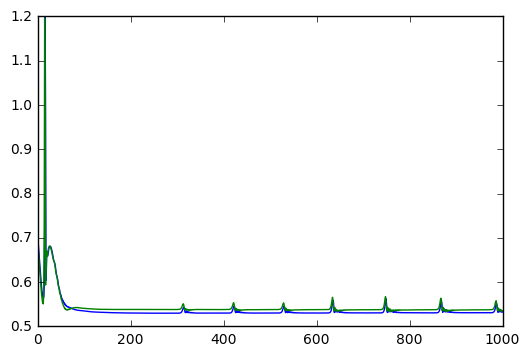

In [440]:
import matplotlib.pyplot as plt

plt.plot(history.history["binary_crossentropy"])
plt.plot(history.history['val_binary_crossentropy'])

plt.show()

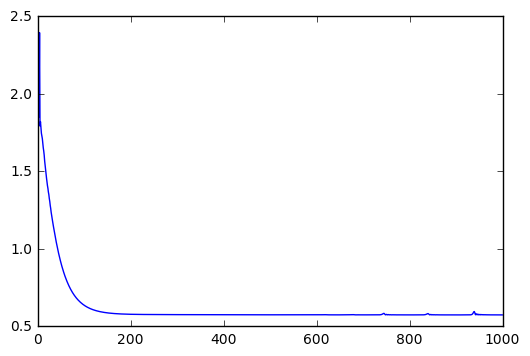

In [408]:
plt.plot(history.history["loss"])

plt.show()

### 5.2 Hey, wait. I hear someone says GBDT!

In [ ]:
X = np.vstack([x.flatten() for x in X])
Y = np.asarray(Y, dtype=np.int)
Xv = np.vstack([x.flatten() for x in Xv])
Yv = np.asarray(Yv, dtype=np.int)

In [ ]:
import lightgbm as lgb

train_data = lgb.Dataset(X, label=Y)
valid_data = lgb.Dataset(Xv, label=Yv, reference=train_data)

param = {'num_leaves':32, 'num_trees':100, 'lambda_l2': 0.01, 'sigmoid': 1 ,'objective':'binary', 'metric':'binary_logloss' }

In [ ]:
gbdt = lgb.train(param, train_data, 100, valid_sets=[valid_data] )

### 5.3 For real prediction

In [448]:
X = np.einsum('ijkl->lijk', np.expand_dims(np.dstack(X), 0))
Y = np.expand_dims(np.asarray(Y, dtype=np.int), 1)

In [444]:
# for real prediction

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, Convolution1D
from keras.regularizers import l2, l1, l1l2
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    Convolution2D(24, 2, 4, border_mode='valid', input_shape=(X.shape[1], X.shape[2], X.shape[3]), W_regularizer=l1l2(2e-5, 0.009), init='lecun_uniform'),
    Activation('relu'),
    Flatten(),
    Dense(96, W_regularizer=l1l2(2e-5, 0.009), init='lecun_uniform'),
    Activation('relu'),
    Dense(1, W_regularizer=l1l2(2e-5, 0.009), init='lecun_uniform'),
    Activation('sigmoid')
])

early_stopping = EarlyStopping(monitor='val_binary_crossentropy', patience=100)
model_check = ModelCheckpoint("Model/model.{epoch:04d}.hdf5", monitor='binary_crossentropy')
opt = SGD(lr=0.08, momentum=0.9, decay=4e-5)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['binary_crossentropy'])

In [449]:
history = model.fit(X, Y, nb_epoch=1000, batch_size=2048, shuffle=True, 
          verbose=0, callbacks=[model_check])
np.savetxt("loss_history2.txt", np.vstack([history.history["loss"], history.history["binary_crossentropy"]]).T, delimiter="\t")

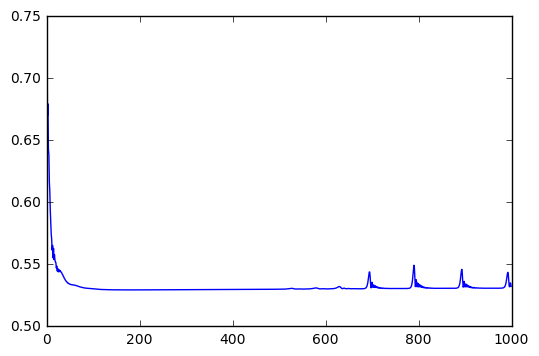

In [450]:
import matplotlib.pyplot as plt

plt.plot(history.history["binary_crossentropy"])

plt.show()

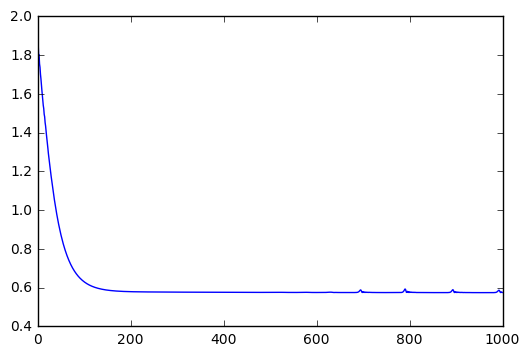

In [451]:
plt.plot(history.history["loss"])

plt.show()

## 6. Result generation

In [462]:
from keras.models import load_model
model = load_model("Model/model.0958.hdf5")

In [463]:
submission = pd.read_csv("./Data/SampleSubmission.csv")
content = []
for row in submission.iterrows():
    content.append(map(int, row[1].ix[0].split('_')))
submission = pd.DataFrame(content, columns=['Season', 'Player', 'Opponent'])

In [464]:
submission = pd.merge(submission, featureselected, left_on=['Season', 'Player'], right_index=True)
submission = pd.merge(submission, featureselected, left_on=['Season', 'Opponent'], right_index=True, suffixes=["Ply", "Opp"])

In [465]:
submission.head()

,Season,Player,Opponent,PlayerResultPly,SigWinPly,SigLosePly,PlayerScorePly,WorPly,WdrPly,WastPly,...,OffdefPFOpp,KeenerSCOREOpp,KeenerEFGMOpp,KeenerOROpp,KeenerDROpp,KeenerASTOpp,KeenerTOOpp,KeenerSTLOpp,KeenerBLKOpp,KeenerPFOpp
0,2017,1112,1116,0.994302,0.982906,0.028490,0.760684,0.501425,0.826211,0.629630,...,0.507123,0.880342,0.871795,0.772080,0.880342,0.868946,0.732194,0.971510,0.957265,0.846154
1,2017,1112,1124,0.994302,0.982906,0.028490,0.760684,0.501425,0.826211,0.629630,...,0.253561,0.712251,0.695157,0.655271,0.732194,0.766382,0.484330,0.561254,0.706553,0.347578
67,2017,1116,1124,0.917379,0.905983,0.330484,0.900285,0.715100,0.475783,0.675214,...,0.253561,0.712251,0.695157,0.655271,0.732194,0.766382,0.484330,0.561254,0.706553,0.347578
2,2017,1112,1137,0.994302,0.982906,0.028490,0.760684,0.501425,0.826211,0.629630,...,0.390313,0.398860,0.407407,0.131054,0.350427,0.461538,0.239316,0.358974,0.393162,0.242165
68,2017,1116,1137,0.917379,0.905983,0.330484,0.900285,0.715100,0.475783,0.675214,...,0.390313,0.398860,0.407407,0.131054,0.350427,0.461538,0.239316,0.358974,0.393162,0.242165


In [466]:
Xv = []
for row in submission.iterrows():
    Xv.append(np.vstack([row[1][map(lambda x:x+u'Ply', featureconfig)], row[1][map(lambda x:x+u'Opp', featureconfig)]]))

In [467]:
Xv = np.einsum('ijkl->lijk', np.expand_dims(np.dstack(Xv), 0))
Yp = model.predict_proba(Xv)

1824/2278 [=======================>......] - ETA: 0s

In [468]:
submission['Prediction'] = Yp

In [469]:
id = []
pred = []
for row in submission.iterrows():
    id.append("{0}_{1}_{2}".format(int(row[1].ix[0]), int(row[1].ix[1]), int(row[1].ix[2])))
    pred.append(row[1].Prediction)

In [470]:
submit = pd.DataFrame({"id":id, "pred":pred}, columns=['id', 'pred'])

In [471]:
submit.to_csv("result.csv", index=False)